
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    Boundary Construction 
Reading boundary points from the file
No. of points at the boundary: 72

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Voronoi tessellations and statistics ....
Generating the plots....


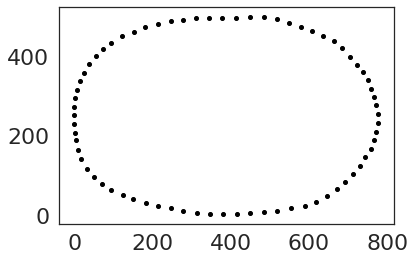

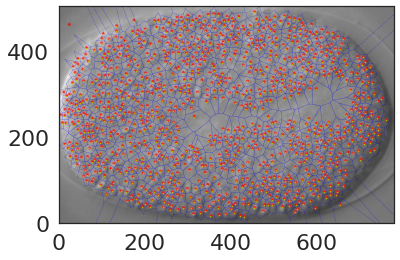

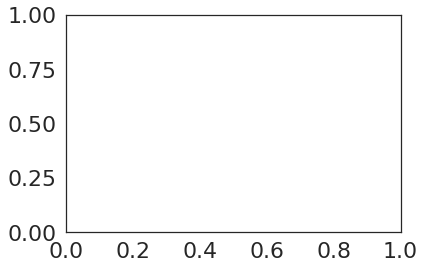

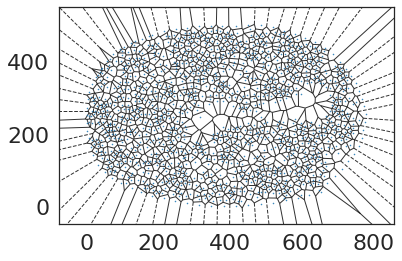

No handles with labels found to put in legend.


Writing into the files......
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~--------------------------------
Plotting the data 


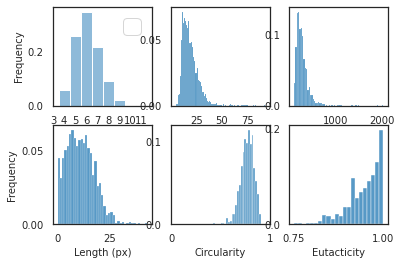

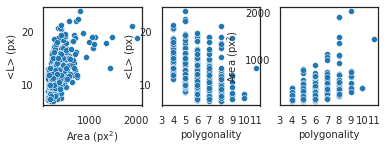

In [1]:
'''
Neha Khetan, 
AsterQuant: 2017 - 2022
@ Athale Lab, IISER Pune

Platform to measure aster statistics  i.e. packing and spatial analysis
Developed for Multi - aster project
Can be extended to multiple systems






* Librariers  required: under import
* Files: 
         1. AsterQuant_V6.py
         2. compute_functions.py
         3. coordinate_merger.py
         4. plot_Quantvoronoi.py
         5. plot_voronoi.py
         6. READ ME File: README_AsterQuant.md
* USAGE: Check README_AsterQuant.md
'''

import sys
import os
import cv2
import numpy as np
from random import uniform


from scipy.spatial import Voronoi, Delaunay , voronoi_plot_2d
from shapely.geometry import MultiPoint, Point, Polygon
from shapely.ops import polygonize
from scipy.spatial import ConvexHull


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import MaxNLocator
from pylab import plot, ginput, show, axis


import plot_voronoi_B as plotdata
import plot_Quantvoronoi as plotQuantdata
import compute_functions as comfun
%matplotlib inline

#############################################################################################################
# 					                       Specify PATHs, filenames, parameters , criterion
#############################################################################################################

# input image path
IPATH_Image         = './expt/' #'./Output_DATA/redo_thickLines/' #../rsk10uM_2021/' #NH4Cl/new/' # './../rsk-dose/1uM/' #'./10uM_RSk/' #'./image/'
# path for input coordinates and boundary points
IPATH_File          = './expt/'
# output path for figures
OPATH_fig			= './output_fig/' # 
# output path for files
OPATH_files			= './output_files/' # 
OffsetAU	    	=  0      # not used now, exists due to historical reasons - pls ignore


vizpt                    = 1  # bool for visual representation of voronoi plot. # 0: minimal bp represented 1: additional points represented but not considered for stats
NumberBoundaryPointsViz  = 25
cuttoff_merge_expt       = 1



# ---------------- User reqd. inputs ----------------------
# Image file
filenameImage            = 'cCelegans2018x' #'Fig4E' # #  #'MAX_Projet_.lif - Series023grt1_cf_0.1851'
px2micron                =  1 # 0.152 		  120.0/150.0 #0.284   # 1 px corresponds to um?# work in progress to read metadata here n infer as in matlab - for now - its an input param for user
extn                     = '.png'
# a name of choice for ur reference
outfilename     	     = 'nem'       # 'zhiyi_b' #'1 microM inh RSK.lif - Image011_CF_0.1804'    # name by which the o/p files should be prefixed or suffixed 
# unit for Quantification CHOOSE whether in px or um
u_scale                  = 'pixel'  # provide as either 'pixel' or 'micron'                 #
# Aster coordinate selection choice
selectImage 		     = 0  # Boolean: 0: Read coordinates from file; 1: Input selects 2: Segmentation 
# Coordinates of asters written to a file
FnameAsterCoor           = 'corr_T_Celegans2018x_scen.out' # 'selected_points.out' #
# Boundary construction method
method                   = 4 	# 1:no boundary ;  3 for circular approx ; 2: offset 4: for reading from file  
# if boundary points are read from a file; specify filename i.e. If method = 4
FnamBoundPoints          = 'corr_T_Celegans2018x_1px_roi.txt'





#############################################################################################################
# 					            Read in the image & extract aster centroids 
img = cv2.imread( IPATH_Image + filenameImage + extn , 0 ) 
h = img.shape[0]
w = img.shape[1]
# mean half dimension along length n width
CellRad  =  (( h/2.0 + w/2.0 )/2.0 )  
NumberBoundaryPoints  = 35



# Choose the aster centers
if selectImage:

	print("Select points or to read from a file set selectImage to 0 and provide the filename\n" )
	f1 = plt.figure(1), plt.imshow( img , origin = 'lower' )
	# aster centroids interactively chosen by the user.
	# After choosing the points - Press enter and close the image window for the code to continue
	data_points = ginput( -1, show_clicks = True , timeout = 0 ) 
	plt.show()
	plt.close()

	wlines=""
	for dp in data_points:
		wlines+=str(dp[0])+'\t'+str(dp[1])+'\n'
	outf = open( IPATH_File + 'selected_points.out','w')
	outf.writelines(wlines)
	outf.close()


else:
	
	inf = open( IPATH_File + FnameAsterCoor , 'r' ) #
	lines = inf.readlines()
	inf.close()

	data_points = []
	for l in lines:
		toks = list(map(float,l.strip().split('\t') ) )
		data_points.append(tuple(toks))





# not needed in the Current experimental data set as the centroids are manually choosen 
# needed for simulation data - as the coordinates of two asters can be same
data_points =  comfun.merge_coordinates( data_points , cuttoff_merge_expt , OffsetAU )



print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("    Boundary Construction ")
if method ==4:
	print("Reading boundary points from the file")
	''' 
	6-7-19: 
	Reading in boundary points for Yash data on C elegang
	'''
	boundary_points = []
	f0    =  open( IPATH_File + FnamBoundPoints  , 'r' )    
	infile0  =  f0.readlines()[0: ] 
	
	xb = []
	yb = []
	for k in range( len( infile0 ) ):
		val = infile0[k].strip().split("	") 
		xb.append( float( val[0])  )
		yb.append( float( val[1]) )  
	boundary_points = zip( xb, yb )
	#print("read bps",  list(boundary_points) )
	boundpt = np.array( list(boundary_points ))
	max_nbp = len(xb);
	fig1 = plt.figure()
	plt.plot( boundpt[:,0], boundpt[:,1] , 'ko' , ms=4 )
	plt.savefig( OPATH_fig + 'BoundaryPoints_' + '.pdf', bbox_inches='tight' , dpi=600 )
	

elif method == 1:
	print("No need to construct boundary ...")
	max_nbp = 0;
	boundary_points = []




#############################################################################################################
# 					                        Optimizing the number of boundary points 
############################################################################################################# 
# 2: Considering expanison of the offset region as long as the packing fraction of all the voronois are within an error
#    the manual approach is automated. points are initialized between inner and outer circles , and that choice of distance is determined arbitarily.
#    while the number of points is optimized. IGNORE THIS FOR NOW. HISTORY
# 3: Just ensures that voronoi vertices are not inside the cell periphery. The infinit points are accounted in the polygonal calculation
#    by truncating them at the cell boundary (not implemented while plotting instead for visual representation a higher number of points
#    are initialized so that infinity points are brought close to the cell periphery)
# ignore the nomencalture -- historical reasons
# work under progress for getting rid of history and have a working script ( to do )	

elif method == 2:
	OuterRad = CellRad 
	max_nbp = 0; 
	max_counter = 0;
	while max_nbp <= 1:
			
		print("Generating boundary points for outer radius:" , OuterRad)
		for nbp in range(  2  , NumberBoundaryPoints ):
			#for nbp in [NumberBoundaryPoints]:
			#print "in loop:", nbp
			#  Generating boundary points on a circle , if required, 
			anglesbound = np.linspace( 0 , 360 , nbp )

			boundary_points = []
			outer_bp        = []
			for ii in range( 0 , len( anglesbound) ):		
				xval , yval = comfun.pointOnCirl(  CellRad , anglesbound[ii] , w , h  , OffsetAU )
				boundary_points.append( [ xval , yval ]  )
				xvalx , yvaly = comfun.pointOnCirl(  OuterRad , anglesbound[ii] , w , h , OffsetAU )
				outer_bp.append( [ xvalx , yvaly ]  )

				# ---------------------------------------------------------------------
		counter      =  0
		points       =  data_points    +  boundary_points 
		vortmp       =  Voronoi( points )
		#----------------------------
		for k in vortmp.vertices:
			chk1 = comfun.checkCircle( k , CellRad  , w , h ) 
			chk2 = comfun.checkCircle( k , OuterRad , w , h )
			#print chk1,chk2;
			#if (((chk1 and chk2)==False) and (((chk1 | chk2)==True)) ):

			if ( (chk1 ==False) and (chk2 ==True) ):
				counter+=1;
				
		if ( (counter> max_counter) and (counter - nbp== 0 )):
			max_counter = counter
			max_nbp     = nbp
		#print "!",  max_nbp 


	OuterRad = OuterRad + 1
	#print max_nbp


elif method ==3 :
	print("Optimizing number of boundary points & Boundary constuction ")


	# method 3
	OuterRad = CellRad
	max_nbp = 0; max_counter = 0
	#print("Generating boundary points for outer radius:" , OuterRad)
	for nbp in range(  1  , NumberBoundaryPoints ):
		#for nbp in [NumberBoundaryPoints]:
		#print "in loop:", nbp
		#  Generating boundary points on a circle , if required, 
		anglesbound = np.linspace( 0 , 360 , nbp )

		# Generating "nbp" boundary points 
		boundary_points = []
		outer_bp        = []
		for ii in range( 0 , len( anglesbound) ):		
			xval , yval = comfun.pointOnCirl(  CellRad , anglesbound[ii] , w , h  , OffsetAU)
			boundary_points.append( [ xval , yval ]  )
			xvalx , yvaly = comfun.pointOnCirl(  OuterRad , anglesbound[ii] , w , h  , OffsetAU)
			outer_bp.append( [ xvalx , yvaly ]  )

		# ---------------------------------------------------------------------
		counter      =  0
		points       =  data_points    +  boundary_points 
		vortmp       =  Voronoi( points )  # Voronoi tessellation done here
		#----------------------------
			
			
		# this checks how many polygon vertices lie outside the cirlce
		for k in vortmp.vertices:
			chk1 = comfun.checkCircle( k , CellRad , w , h ) 
				
			if ( (chk1 ==False) ):
				counter+=1;
			
		# iteratively, checks whether the points that lie outside is larger than the earlier or not.
		# Idea is to select for the Minimal number of input boundary point for which the maximal number of polygon 
		# vertices are ON the circumference or outside the cell - so that aster centered cells account for the boundary
		if ( (counter > max_counter) ):
			#print (counter - nbp ) , counter
			max_counter = counter
			max_nbp     = nbp
				
		#print( "!",  max_nbp , nbp , counter)


elif method ==30 :
	print("Optimizing number of boundary points & Boundary constuction ")
	max_nbp = 0; max_counter = 0
	#print("Generating boundary points for outer radius:" , OuterRad)
	for nbp in range(  1  , NumberBoundaryPoints ):
		#for nbp in [NumberBoundaryPoints]:
		#print "in loop:", nbp
		#  Generating boundary points on a circle , if required, 
		anglesbound = np.linspace( 0 , 360 , nbp )

		# Generating "nbp" boundary points 
		boundary_points = []
		outer_bp        = []
		inner_bp        = []
		for ii in range( 0 , len( anglesbound) ):		
			xval , yval    = comfun.pointOnCirl(  CellRad , anglesbound[ii] , w , h , OffsetAU  )
			boundary_points.append( [ xval , yval ]  )


			Outxval , Outyval  = comfun.pointOnCirl(  CellRad  , anglesbound[ii] , w , h , OffsetAU )
			Inxval  , Inyval   = comfun.pointOnCirl(  CellRad  , anglesbound[ii] , w , h  , OffsetAU)
			outer_bp.append( [ xvalx , yvaly ]  )

		# ---------------------------------------------------------------------
		counter      =  0
		points       =  data_points    +  boundary_points 
		vortmp       =  Voronoi( points )  # Voronoi tessellation done here
		#----------------------------
			
			
		# this checks how many polygon vertices lie outside the cirlce
		for k in vortmp.vertices:
			chk1 = comfun.checkCircle( k , CellRad , w , h ) 
				
			if ( (chk1 ==False) ):
				counter+=1;
			
		# iteratively, checks whether the points that lie outside is larger than the earlier or not.
		# Idea is to select for the Minimal number of input boundary point for which the maximal number of polygon 
		# vertices are ON the circumference or outside the cell - so that aster centered cells account for the boundary
		if ( (counter > max_counter) ):
			#print (counter - nbp ) , counter
			max_counter = counter
			max_nbp     = nbp
				
		#print( "!",  max_nbp , nbp , counter)		
else:
	print("ERRROR!! ")

	# -------------------------------------------------------------	
print("No. of points at the boundary:" ,  max_nbp )
#print("Multiple runs for randomized points")
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")




#############################################################################################################
# 					        Statistics on tesellating with the optimized number of boundary points
#############################################################################################################

print("Voronoi tessellations and statistics ....")

if method == 3:
	nRuns = 3 
else:
	nRuns = 1


for nRun in range( 0, nRuns ):
	polygonArea = []
	polygonSides = []
	AllLengths   = []
	AllEutac     = []




	# -- var are under for loop
	tmp =[]
	tmpArea =[]
	output =[]
	tot_area     = 0
	LengthPolygon = []
	# -- end of the for loop variables
			

		
	if method == 1:
		inner_bp = []
		boundpt  = []

	elif method ==4:
		inner_bp = boundpt


	elif method ==3:
		# Multiple runs with the same number of boundary points which are equidistant to each other - 
		# however the starting point is randomized - just to ensure the result for the peripheral asters is 
		# not due to the position of the boundary points that are introduced 
		#for nRuns in range( 0, nRuns ):
		#  Generating boundary points on a circle 
		angles = np.linspace( 0 , 360 , max_nbp  )
		angle_diff = round(angles[2] - angles[1])
		new_angles = angles + angle_diff*np.random.uniform( 0 , 1 )
		angles = new_angles
		inner_bp = []
		for ii in range( 0 , len( angles) ):		
			xval , yval = comfun.pointOnCirl(  CellRad , angles[ii] , w , h , OffsetAU )
			inner_bp.append( [ xval , yval ]  )
			boundpt = inner_bp
					




	else:
		print("Pls. check the input param.")

	# ---------------------------------------------------------------------
		
	if method == 1:
		points = data_points
	elif method ==3:
		print("Tesselations with optimized boundary points.")
		points       =  data_points    +  inner_bp
	else:
		points       =  data_points    +  inner_bp.tolist()



	vor           =  Voronoi( points )

	# Iterating over the input points
	for i , p in enumerate( vor.points ):
		#print 'i:=' +str(i) + ' \t indx of vor region:' +  str(  vor.point_region[i] )
		# i is an index of the input point
		# j = vor.point_region[i] gives the index of the region created by ith input point
		# vor.regions[j ] gives the jth region among all the regions. 
		# ----------    if a region is unbound it will have -1 in the list among other elements. 
				
		region = vor.regions[ vor.point_region[i] ]
		area_region = 0
			

		polyLength = []
		# For area calculation: 		
		if -1 not in region:              # if it has infinite bound, region will have a '-1' , Ignore those
			# calculate lengths
			LenCounter = 0
			polygonverticesIndx = vor.regions[vor.point_region[i]]				
			# increment the polygonality if at the boundary
						

			flagLen = 0 # All points inside 
			for k in vor.vertices[polygonverticesIndx]:
				chk1 = comfun.checkCircle( k , CellRad , w , h ) 
				
				if ( (chk1 ==False) ):
					LenCounter=1
					flagLen = 1
					break

			if (flagLen == 0):
						
				# Lengths of polygon sides
				vertexReg = vor.vertices[region]
				for ivR in range(-1,len(vertexReg)-1):
					ivR1 = vertexReg[ivR]
					ivR2 = vertexReg[ivR + 1 ]
					sqdist =comfun.get_sdistance( ivR1 , ivR2 )
					polyLength.append( round(np.sqrt(sqdist)*px2micron ,3 ) )

				# Area of each polygon
				parea =  comfun.calculate_area( vor , i )
				tot_area+= parea*px2micron*px2micron			 # calculate total area 
				area_region+=parea*px2micron*px2micron           # calculate area of each region
				#print  'ind pt:', i , 'point:', p , 'N poly:' , len(vor.regions[vor.point_region[i]]) , 'Area of reg:', round( area_region , 2 )
					

			output.append( [ p , len(polygonverticesIndx)+LenCounter , round( area_region , 3 ) ] )
			tmpArea.append( round( area_region , 3 ) )
			tmp.append( ( len(polygonverticesIndx)+LenCounter) )
			LengthPolygon.append( polyLength  )			


	# Storing the values of the voronoi areas
	# ------- Output the coords , Polygon , Area of each region
	npol_area = []
	AreaCell = 0
	for j , val in enumerate( output ):	
		npol_area.append( [  val[0][0] , val[0][1] , val[1] , val[2] ])
		AreaCell+=val[2]


	# ===============================================================================
	#  Calculate the nearest neighbour distances
	# for each voronoi point find its region then find all its neighboring regions
	# =================================================================================
	near_neigh = {}
	for p1 in range( 0 , len( vor.points) ):
		near_neigh[p1] = []
		for p2 in range( 0 , len( vor.points)):
			if p1 == p2 :
				continue

			r1 = vor.regions[ vor.point_region[ p1 ] ]
			r2 = vor.regions[ vor.point_region[ p2 ] ]    
					
			# consider only bounded regions, ignore the unbounded ones
			if ( -1 not in r1 ) & ( -1 not in r2 ): 
					 
				commonEdge = list( set(r1) & set(r2)) 
				if len( commonEdge ) == 0:
					continue

				near_neigh[p1].append(p2)
				#print p1 , p2 ,"\n" , "........" , r1 ,  r2
				#print "Inter:" , "...." , list( set(r1) & set(r2))
				# print "whr am i???"

	near_neigh_distance = {}
	for p1 , v in near_neigh.items():

		if len(v) == 0:
			continue

		#print p1, len(v)
		near_neigh_distance[p1] = [[],0]
		coor1 =  vor.points[ p1 ] 
		for p2 in v:
			coor2=vor.points[ p2 ]
			dist = np.sqrt(  ( coor1[0] - coor2[0] )**2 + ( coor1[1] - coor2[1] )**2 )
			near_neigh_distance[p1][0].append( round( dist , 2 )*px2micron )
				
		mean= round( np.mean( np.array(near_neigh_distance[p1][0]) ) , 2 )
		near_neigh_distance[p1][1]=mean
		#print near_neigh_distance[p1]


	near_neigh_distance = {}
	near_neighborPoints = {}
	for p1 , v in near_neigh.items():
		if len(v) == 0:
			continue

		#print p1, len(v)
		near_neigh_distance[p1] = [[],0]
		near_neighborPoints[p1] = [] 
		coor1 =  vor.points[ p1 ] 
		for p2 in v:
			coor2=vor.points[ p2 ]
			dist = np.sqrt(  ( coor1[0] - coor2[0] )**2 + ( coor1[1] - coor2[1] )**2 )
			near_neigh_distance[p1][0].append( round( dist , 2 )*px2micron )
			near_neighborPoints[p1].append( p2 )
						
		mean= round( np.mean( np.array(near_neigh_distance[p1][0]) ) , 2 )
		near_neigh_distance[p1][1]=mean
		#print near_neigh_distance[p1]


	## Eutactic asters
	for p1 ,n1 in near_neighborPoints.items():
		Mtmat = []
		for p2 in n1:
			coord1 = vor.points[p1]
			coord2 = vor.points[p2]
			Mtmat.append(coord2 - coord1)
				
		Mtmat = np.array( Mtmat)
		Mtmat_t = np.transpose(Mtmat)
		MatS   =  Mtmat @ Mtmat_t
		MatT   = np.trace( MatS)
		eutac  = MatT/(( np.sqrt( np.trace( MatS @ MatS)) * np.sqrt(2)))
		AllEutac.append( np.round(eutac,2))



















	# ==============================================================================
	#                                         PLOTTING
	# print 'hi', CellRad
	# ==============================================================================

	if vizpt:
		bp4viz = NumberBoundaryPointsViz
	else:
		bp4viz = max_nbp

		
	#plotdata.plotvoronoiOutput( data_points , vor , CellRad, inner_bp, outer_bp , nRuns , outfilename , OPATH_fig  , method  , bp4viz , w , h , OffsetAU , img )
	print( "Generating the plots....")
	#plotdata.plotvoronoiOutput( data_points , vor , CellRad, nRun , outfilename , OPATH_fig  , method  , bp4viz , w , h , OffsetAU , img , boundpt  )
	inputimg = mpimg.imread( IPATH_Image + filenameImage + extn ) #'.tif')
	plotdata.plotvoronoiOverlay( vor , data_points , CellRad , nRun ,  outfilename , OPATH_fig  , bp4viz , w , h , OffsetAU , inputimg , method, boundpt ) 	
	plotdata.plotvoronoiRaw( vor ,  CellRad , nRun , boundpt , outfilename , OPATH_fig ,  w , h , OffsetAU ,  inputimg , method  )


	# =====================================================================================
	#
	#   						WRITE INTO THE FILES
	# --------------------------------------------------------------
	#np.savetxt(  OPATH_files + 'Phallusia_' +  str( "%s" % outfilename ) + '_nRun_'+ str( "%s" %  nRuns ) + '.out' ,  npol_area  , fmt='%.6f'  ,  delimiter='\t') 
		
	AllnndVal = []	
	# Near neigbor distances: in um
	outfileNND = 'All_NND' + str( "%s" % outfilename ) + '_nRun_'+ str( "%s" %  nRun ) + '.out'
	fo = open( OPATH_files +  outfileNND , "w")
	for k, v in near_neigh_distance.items():
		fo.write('\t'.join(map(str, v[0])) + "\n" )
		AllnndVal.append( v[0])
	fo.close()
	outfileEutac = 'AllEutac' + str( "%s" % outfilename ) + '_nRun_'+ str( "%s" %  nRun ) + '.out'
	np.savetxt(  OPATH_files + outfileEutac + '.out' ,  np.array(AllEutac)  , fmt='%.2f'  ,  delimiter='\t') 			
	#print "packing fraction"
	totalCellArea = (CellRad*CellRad*22.0)/7.0
	#print  nRuns , round( ( (AreaCell)/( totalCellArea) )*100 , 2 )

	polygonSides.append( tmp )
	polygonArea.append( tmpArea )
	AllLengths.append( (LengthPolygon) )

	# ===================================================================================================================================================================
	print("Writing into the files......")
	# each row corresponds to one run while asters are in columns
	wlines=''
	for v , va , vs in zip(AllLengths, polygonArea, polygonSides ):
		for v1 , v1a , vs1 in zip(v,va , vs ) :
			# Polygonality | Area | Lengths of each side
			wlines+= str( vs1 ) + '\t' +  str( v1a ) +  '\t' + '\t'.join(map(str,v1))+'\n'

	outf=open(OPATH_files + 'polygonAreaLengths' +  str( "%s" % outfilename ) + '_nRun_'+ str( "%s" %  nRun ) + '.out','w')
	outf.writelines(wlines)
	outf.close()


	# ===================================================================================================================================================================
	# Plotting the data
	print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~--------------------------------")
	print("Plotting the data ")
	plotQuantdata.plot_AllQdata( polygonSides ,  AllnndVal , AllLengths , polygonArea  , AllEutac ,  u_scale  , OPATH_files	, OPATH_fig , outfilename , nRun  )

